#  Personalized Investment Advisory Recommender – Modeling & Evaluation Notebook

---

##  **Project Context & Motivation**
In emerging markets like Kenya, many first‑time and low‑income investors face overwhelming choices — SACCOs, money market funds, pension plans, bonds, and more — yet often lack professional financial advisory support.  
This leads to decision paralysis, under‑investment, and missed opportunities for long‑term wealth building.

Our project aims to close this advisory gap by building a **data‑driven personalized recommender system** that suggests *the most suitable investment types* for each user based on:
- Demographics (age, gender, location)
- Risk appetite
- Financial literacy & past financial behavior
- Self‑reported saving and investment goals

By combining **machine learning, explainable AI, and local financial domain insights**, we aim to give every user — even first‑time investors — personalized, confidence‑driven investment guidance.

---

##  **What This Notebook Covers**
- Load and briefly explore the cleaned FinAccess dataset
-  Feature engineering & vectorization:
  - One‑hot encoding of categorical variables (e.g., risk_appetite)
  - Scaling of numeric features (e.g., age, literacy index)
  - Additional engineered features (e.g., savings rate, risk‑adjusted usage)
-  Quick Exploratory Data Analysis (EDA): distributions & relationships
- ⚙ Train/test split with stratification

###  Modeling pipeline 
For each model, we:
- Train & validate
- Hyperparameter tuning (where relevant)
- Evaluate with accuracy, precision, recall, ROC‑AUC, plus recommendation‑specific metrics (e.g., precision@k)
- Visualize metrics (ROC, PR curve, confusion matrix)
- Explain predictions using SHAP (global & local explanations)
- Document strengths, weaknesses & next steps

Models to build:
- Baseline rule‑based recommender
- Logistic Regression
- Random Forest
- Gradient Boosting (XGBoost & LightGBM,knn)
- Deep Learning Recommender

---

##  **Final Deliverables**
- Trained, deployment‑ready best model (`.pkl` / `.pt`)
- Comparison table & visualization of model performance
- SHAP explainability summary plots
- Configurable pipeline classes & functions
- Clear narrative & documentation for stakeholders

---


---
## Importing Core Libraries

Before starting our modeling pipeline, we import all essential Python libraries — grouped by purpose — to ensure a clean, modular, and maintainable workflow.

**Categories & Purpose:**
- **Data manipulation & wrangling:** `pandas`, `numpy` – for structured data handling, transformation, and aggregation
- **Visualization & EDA:** `matplotlib`, `seaborn` – for visual exploration, distributions, correlations, and plots to support feature engineering
- **Machine Learning & Evaluation:** `scikit-learn` – classic models, preprocessing, splitting, metrics; `xgboost`, `lightgbm` – advanced gradient boosting
- **Deep Learning (optional):** `torch` / `keras` – for neural network recommender models capturing complex patterns
- **Explainability:** `shap` – to build trust by explaining model predictions (global & local feature importance)
- **Persistence & utilities:** `joblib` – for saving models; `warnings` – to suppress clutter in output

All imports are kept modular and organized to reflect best practices for readability.

---


In [145]:
# Import all required Python libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, roc_curve, precision_recall_curve
)

import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')


- All required libraries are now imported.  

 

---
##  Load Cleaned Dataset

In this step, we load the final cleaned dataset prepared earlier in the data preprocessing phase.  
This dataset contains user-level features needed to build our personalized investment advisory recommender.

---


In [146]:
#  Loads the pre-cleaned dataset from CSV and prints its shape.

def load_dataset(filepath):
    df = pd.read_csv(filepath)
    print(f" Dataset loaded successfully. Shape: {df.shape}")
    return df

# Update with your actual local path
file_path = r"C:\Users\hp\OneDrive\Desktop\DSF-FT12\DS- Phase5\Group4_Capstone_Final_Project\final_refined.csv"

df = load_dataset(file_path)
df.head()


 Dataset loaded successfully. Shape: (20871, 392)


,householdid,county,area_type,gender,age_of_respondent,no_of_household_mebers,livelihoodcat,Quintiles,Education,Marital,...,insurance_including_NHIF_use,All_Insurance_excluding_NHIF_use,PWD,Latitude,Longitude,has_account,has_savings,has_credit,has_mobile,receives_remittance
0,107141431,garissa,urban,male,29,5,dependent,fourth,tertiary,married/living with partner,...,never used,never used,without disability,-0.435423,39.636586,0,0,0,0,0
1,10712933,garissa,urban,male,60,11,other,second,primary,married/living with partner,...,never used,never used,without disability,0.058794,40.305006,0,0,0,0,0
2,140173183,busia,urban,female,35,2,casual worker,fourth,primary,divorced/separated,...,never used,never used,without disability,0.636836,34.277390,0,0,0,0,0
3,122137153,kiambu,urban,male,24,1,casual worker,middle,secondary,single/never married,...,never used,never used,without disability,-1.251917,36.719076,0,0,0,0,0
4,121193116,murang'a,urban,female,20,1,dependent,highest,secondary,single/never married,...,never used,never used,without disability,-0.795820,37.131085,0,0,0,0,0


-   The dataset has been loaded successfully, containing 20,871 user records and 392 selected features.  
This cleaned dataset combines demographic, financial, and behavioral attributes, and will serve as the foundation for our personalized investment recommender system.


##  Dataset Overview & Missing Values Analysis

We begin by exploring the structure of our dataset using `df.info()`.  


In [147]:
df.info()

# Missing values overview
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing': missing, 'Percent': missing_pct})
missing_df[missing_df['Missing'] > 0].sort_values('Percent', ascending=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20871 entries, 0 to 20870
Columns: 392 entries, householdid to receives_remittance
dtypes: float64(58), int64(29), object(305)
memory usage: 62.4+ MB


,Missing,Percent


Key details:
- The dataset contains **20,871 rows** and **392 columns**.
- It has a mix of data types:
  - **305 object** (categorical/text) columns
  - **58 float64** (numerical) columns
  - **29 int64** (numerical) columns
- Total memory usage is approximately **62.4 MB**.

---

#### ⚠ Missing Values Overview
Next, we analyze missing values to assess data quality:
- Calculate the **count** and **percentage** of missing values per column.



 --- 

##  **Exploratory Data Analysis (EDA)**

In this section, we explore and visualize the dataset to understand its structure, detect missing values, identify distributions, and spot potential outliers or patterns.  
Key steps included:
- Checking data types and summary statistics  
- Visualizing distributions of numeric variables  
- Analyzing categorical feature value counts  
- Checking correlations and potential multicollinearity  
- Investigating target balance and potential imbalance

---

## **Feature Engineering**

Here we transform and enrich the dataset to improve model performance.  
Key feature engineering steps:
- Creating new numeric features (e.g., `risk_adjusted_savings_rate`)
- Scaling numeric features like `literacy_scaled`
- Grouping or binning age into `age_bucket`
- Creating binary flags such as `is_youth`
- Counting investment products used (`total_investment_products_used`)
- Converting categorical features to category dtype for memory efficiency

These engineered features help capture hidden patterns and make the data more suitable for machine learning.

 ---

### Target Variable Distribution: `Investment_usage_fnl`

In this step, we explore the distribution of our target variable **`Investment_usage_fnl`**, which indicates whether respondents use investment products.


Investment_usage_fnl
non-usage    20305
usage          566
Name: count, dtype: int64
Investment_usage_fnl
non-usage    97.288103
usage         2.711897
Name: proportion, dtype: float64


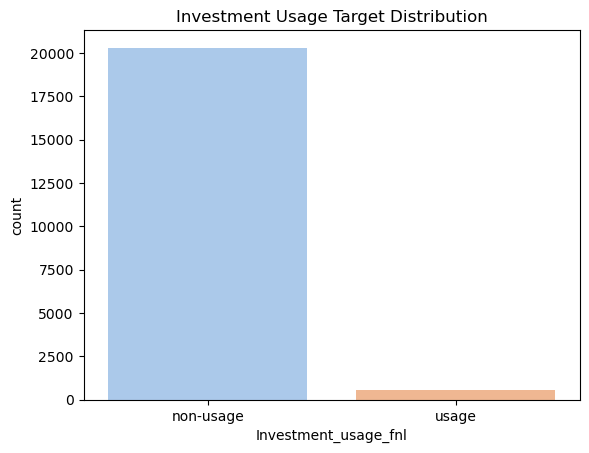

In [148]:
print(df['Investment_usage_fnl'].value_counts())
print(df['Investment_usage_fnl'].value_counts(normalize=True)*100)

sns.countplot(x='Investment_usage_fnl', data=df, palette='pastel')
plt.title('Investment Usage Target Distribution')
plt.show()


Key findings:
- The dataset is highly imbalanced:
  - **non-usage**: 20,305 observations (~97.3%)
  - **usage**: 566 observations (~2.7%)

We use:
- `value_counts()` to see the raw counts.
- `value_counts(normalize=True)*100` to see the percentage distribution.
- A **Seaborn countplot** to visualize the class imbalance.



In [149]:
df.describe()


,householdid,age_of_respondent,no_of_household_mebers,CalcExpenditure,total_monthly_expenditure,no_respodent_per_hh,hhWeight,Informal_group_membership,Above16_Total,Above16,...,nC1_42,nC1_43,prodsum1,Latitude,Longitude,has_account,has_savings,has_credit,has_mobile,receives_remittance
count,2.087100e+04,20871.000000,20871.000000,20871.000000,20871.000000,20871.000000,20871.000000,20871.000000,20871.000000,20871.0,...,20871.000000,20871.000000,20871.000000,20871.000000,20871.000000,20871.0,20871.0,20871.0,20871.0,20871.0
mean,1.827764e+08,39.271429,4.215946,11576.118340,13082.757031,39.196062,683.165156,0.709405,3.224330,1.0,...,0.003210,0.003066,3.936563,-0.418699,36.651618,0.0,0.0,0.0,0.0,0.0
std,3.077598e+08,17.210021,2.512658,9550.351583,13893.309701,17.228980,594.646933,4.415607,2.328236,0.0,...,0.056569,0.055292,3.227992,1.557240,1.826467,0.0,0.0,0.0,0.0,0.0
min,1.010095e+07,16.000000,1.000000,100.000000,1900.000000,16.000000,39.615500,0.000000,1.000000,1.0,...,0.000000,0.000000,0.000000,-4.617228,33.955648,0.0,0.0,0.0,0.0,0.0
25%,1.061733e+08,26.000000,2.000000,4353.333333,5000.000000,26.000000,350.589934,0.000000,2.000000,1.0,...,0.000000,0.000000,1.000000,-1.069760,35.032543,0.0,0.0,0.0,0.0,0.0
50%,1.221172e+08,35.000000,4.000000,8860.000000,10000.000000,35.000000,556.911105,0.000000,2.000000,1.0,...,0.000000,0.000000,3.000000,-0.431421,36.651860,0.0,0.0,0.0,0.0,0.0
75%,1.380495e+08,50.000000,6.000000,16200.000000,15000.000000,50.000000,801.331391,1.000000,4.000000,1.0,...,0.000000,0.000000,6.000000,0.314269,37.664312,0.0,0.0,0.0,0.0,0.0
max,1.341571e+10,105.000000,20.000000,45953.333333,190000.000000,110.000000,14660.199401,246.000000,20.000000,1.0,...,1.000000,1.000000,22.000000,4.919529,41.875678,0.0,0.0,0.0,0.0,0.0


###  Users per Investment Product

Here we explore which specific investment products are most popular among respondents.
We:
- Select columns indicating product usage (`save_bank`, `save_sacco`, etc.)
- Sum each column to get the total number of users for each product.
- Plot a bar chart to visualize which products are most used.

This helps identify the most and least adopted products in our dataset.


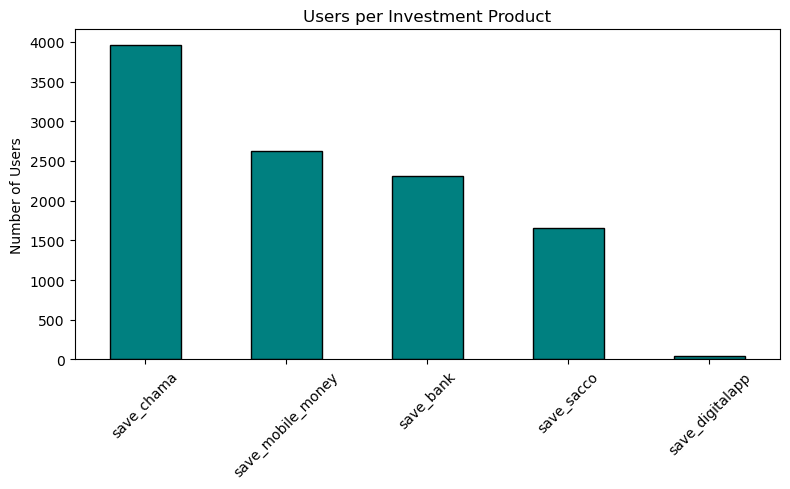

In [150]:
# Define usage columns
usage_cols = ['save_bank', 'save_sacco', 'save_mobile_money', 'save_chama', 'save_digitalapp']

# Count number of users for each product
product_counts = df[usage_cols].sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(8, 5))
product_counts.plot(kind='bar', color='teal', edgecolor='black')
plt.title('Users per Investment Product')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


###  Sparsity of Product Usage Data

We measure how sparse the product usage data is:
- Sparsity shows the percentage of cells that are zeros (i.e., respondents **not** using a product).
- High sparsity indicates most people use few products.

This helps us understand data density before building recommendation models or doing feature engineering.


In [151]:
# Calculate sparsity:

total_cells = df[usage_cols].shape[0] * df[usage_cols].shape[1]
total_nonzeros = np.count_nonzero(df[usage_cols])
sparsity = 1 - (total_nonzeros / total_cells)

print(f"Sparsity of usage matrix: {sparsity:.2%}")


Sparsity of usage matrix: 89.85%


###  Education Level vs. Investment Usage

We analyze how investment product usage varies by education level.

Using a crosstab normalized by index, we compute:
- Percentage of respondents **with each education level** who use or don’t use investment products.

This helps identify if higher education correlates with higher product adoption.


In [152]:
# Education
pd.crosstab(df['Education'], df['Investment_usage_fnl'], normalize='index')*100


Investment_usage_fnl,non-usage,usage
Education,,
other,100.000000,0.000000
primary,99.182308,0.817692
secondary,97.426821,2.573179
tertiary,89.509982,10.490018


###  Numeric Variables vs. Investment Usage

We visualize how selected numeric variables differ between respondents who use and don’t use investment products:
- `monthly income`
- `fl_score` (financial literacy score)
- `age_of_respondent`

Using boxplots helps us see:
- Typical range and median for each group
- Outliers and skewness
- Whether product users tend to have higher income, financial literacy, or different age distribution


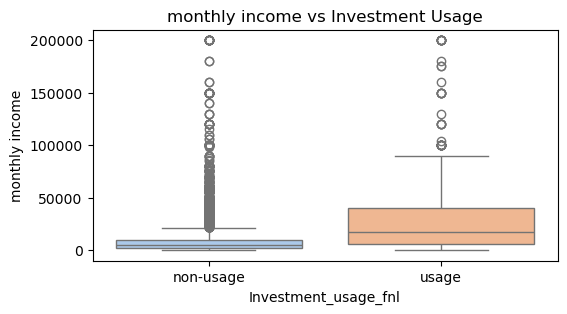

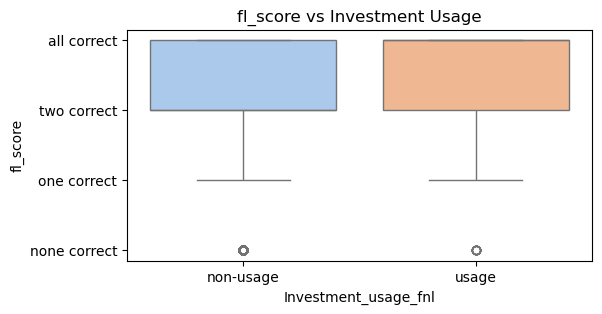

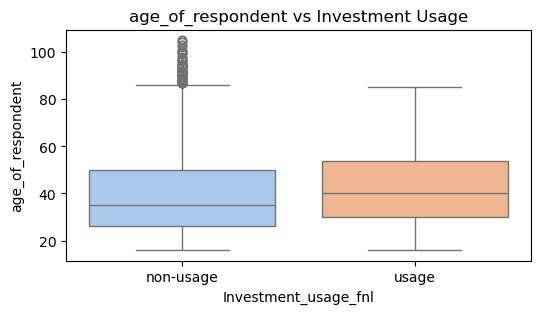

In [153]:
# Plot boxplots of each numeric column vs. Investment usage
for col in ['monthly income','fl_score','age_of_respondent']:
    plt.figure(figsize=(6,3))
    sns.boxplot(x='Investment_usage_fnl', y=col, data=df, palette='pastel')
    plt.title(f'{col} vs Investment Usage')
    plt.show()


###  Convert Usage Flags to Numeric

We identify all columns ending with `_use` that track product usage as `'never used'` or `'used'`.

We map them to numeric:
- `'never used' → 0`
- `'used' → 1`

This prepares the data for modeling, as most ML algorithms require numeric inputs.


In [154]:
# Identify all binary usage flag columns
use_flags = [col for col in df.columns if col.endswith('_use')]

# Map categorical values to numeric: 'never used' -> 0, 'used' -> 1
df[use_flags] = df[use_flags].apply(lambda col: col.map({'never used': 0, 'used': 1}))


###  Convert Disability Status to Numeric

The column `PWD` indicates whether a respondent has a disability.
We map:
- `'without disability' → 0`
- `'with disability' → 1`

This prepares the feature for machine learning models.


In [155]:
# Map disability status to numeric: without disability → 0, with disability → 1
df['PWD'] = df['PWD'].map({'without disability': 0, 'with disability': 1})


###  Create Age Groups

We create a categorical feature `age_group` by binning `age_of_respondent` into ranges:
- 18–25
- 26–35
- 36–50
- 51–65
- 66+

This makes it easier to analyze and visualize age patterns and can also be useful for modeling categorical age effects.


In [156]:
# Create age group categories based on age_of_respondent
df['age_group'] = pd.cut(
    df['age_of_respondent'],
    bins=[17, 25, 35, 50, 65, 100],
    labels=['18-25', '26-35', '36-50', '51-65', '66+']
)


###  Create Household Size Categories

We group `no_of_household_mebers` into categorical bins:
- 1–2 members
- 3–4 members
- 5–6 members
- 7–10 members
- 11+ members

This helps explore whether larger households differ in investment behavior and simplifies analysis.


In [157]:
# Create household size category based on number of household members
df['hh_size_cat'] = pd.cut(
    df['no_of_household_mebers'],
    bins=[0, 2, 4, 6, 10, 20],
    labels=['1-2', '3-4', '5-6', '7-10', '11+']
)


###  Create Urban/Rural Binary Feature

We transform the `area_type` column into a numeric feature:
- `urban → 1`
- `rural → 0`

This makes it easier for machine learning models and helps us analyze investment patterns by urban vs. rural respondents.


In [158]:
# Map area type to binary: urban → 1, rural → 0
df['is_urban'] = df['area_type'].map({'urban': 1, 'rural': 0})


###  Create Savings Ratio

We engineer a new feature `savings_ratio`:
- Calculated as: `total_monthly_expenditure / (monthly income + 1)`
- Adding `+1` avoids division by zero.

This feature helps capture how much of a respondent’s income is spent, which may relate to their likelihood to invest.


In [159]:
# Create savings ratio: expenditure divided by (monthly income + 1 to avoid division by zero)
if 'monthly income' in df.columns and 'total_monthly_expenditure' in df.columns:
    df['savings_ratio'] = df['total_monthly_expenditure'] / (df['monthly income'] + 1)


###  Encode Categorical Variables

We one-hot encode the following categorical features:
- `gender`, `age_group`, `county`, `Education`, `Marital`, `livelihoodcat`, `Quintiles`

Using `drop_first=True` drops the first category in each to avoid multicollinearity.
This prepares data for machine learning models that require numeric inputs.


In [160]:
# Define categorical columns to encode
categorical_cols = ['gender', 'age_group', 'county', 'Education', 'Marital', 'livelihoodcat', 'Quintiles']

# One-hot encode categorical variables, dropping first category to avoid multicollinearity
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


###  Check Encoded Feature Names

After one-hot encoding, the dataframe can have many new columns (especially from high-cardinality features like `county`).

We print:
- Total number of columns
- Sample of first and last few column names

This helps verify that encoding worked correctly and spot any unexpected features.


In [161]:
print(df_encoded.columns)


Index(['householdid', 'area_type', 'age_of_respondent',
       'no_of_household_mebers', 'CalcExpenditure',
       'total_monthly_expenditure', 'digital loans', 'no_respodent_per_hh',
       'ID_card', 'hhWeight',
       ...
       'Marital_widowed', 'livelihoodcat_casual worker',
       'livelihoodcat_dependent', 'livelihoodcat_employed',
       'livelihoodcat_other', 'livelihoodcat_own business',
       'Quintiles_highest', 'Quintiles_lowest', 'Quintiles_middle',
       'Quintiles_second'],
      dtype='object', length=456)


###  Standardize Numeric Features

We scale selected numeric columns (`age_of_respondent` and `no_of_household_mebers`) using StandardScaler:
- Transforms each feature to mean = 0 and standard deviation = 1
- Helps many machine learning algorithms converge faster and avoid bias toward larger-scale features.


In [162]:
# List of numeric columns to scale
numeric_cols = ['age_of_respondent', 'no_of_household_mebers']

# Initialize and apply scaler
scaler = StandardScaler()
df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])


###  Age Distribution of Respondents

We visualize the distribution of respondents' ages:
- Histogram shows how many respondents fall into each age range
- KDE curve helps see the overall shape (e.g., skewness, peaks)

This helps us understand the age profile of our dataset.


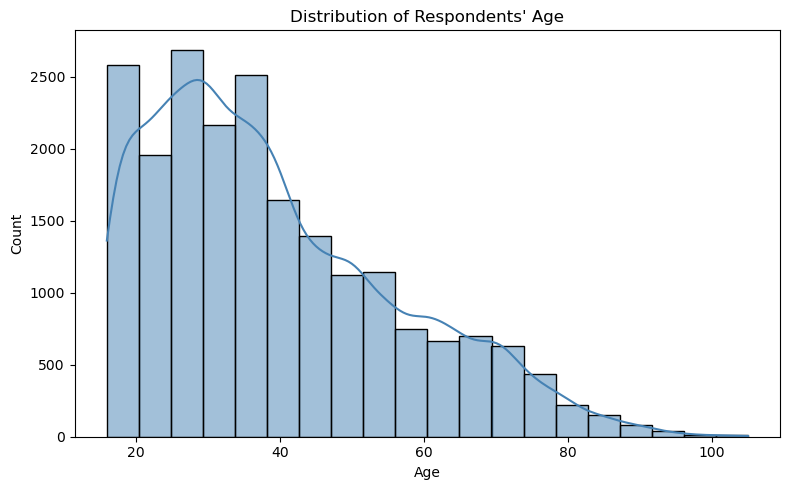

In [163]:
# Plot distribution of age_of_respondent
plt.figure(figsize=(8, 5))
sns.histplot(df['age_of_respondent'], bins=20, kde=True, color='steelblue')
plt.title("Distribution of Respondents' Age")
plt.xlabel('Age')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


###  Number of Respondents by Area Type

We visualize how many respondents come from urban vs. rural areas.
This helps us see if the sample is balanced or biased toward one area type.


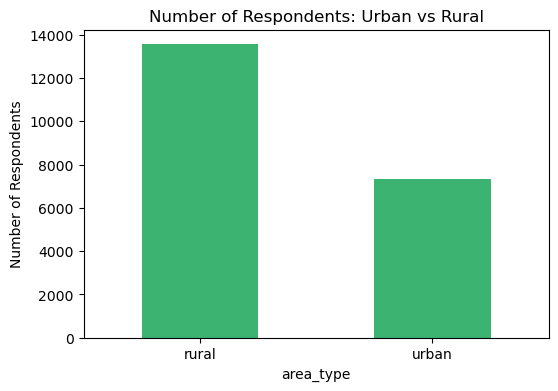

In [164]:
# Plot number of respondents by area type
plt.figure(figsize=(6,4))
df['area_type'].value_counts().plot(kind='bar', color='mediumseagreen')
plt.title('Number of Respondents: Urban vs Rural')
plt.ylabel('Number of Respondents')
plt.xticks(rotation=0)
plt.show()


###  Gender Distribution

We visualize the proportion of male vs. female respondents as a pie chart.
This helps understand the gender balance in our dataset.


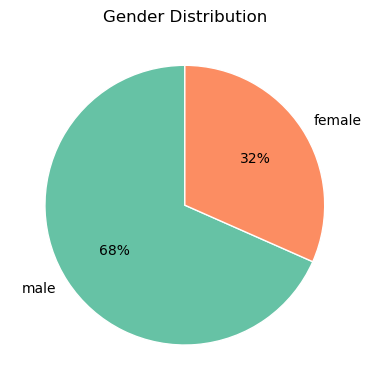

In [165]:
# Plot gender distribution as a pie chart
plt.figure(figsize=(6, 4))
df['gender'].value_counts().plot.pie(
    autopct='%1.0f%%',
    colors=['#66c2a5', '#fc8d62'],
    startangle=90,
    wedgeprops={'edgecolor': 'white'}
)
plt.title('Gender Distribution')
plt.ylabel('')
plt.tight_layout()
plt.show()


###  Respondents by Education Level

We visualize how many respondents fall into each education category.
Ordering bars by frequency makes it easy to see which education levels are most common in the dataset.


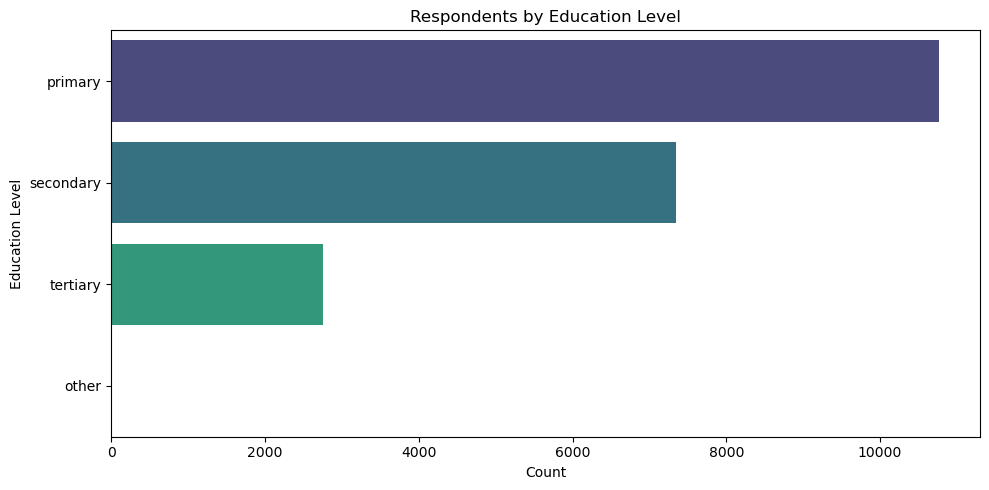

In [166]:
# Plot count of respondents by education level
plt.figure(figsize=(10, 5))
sns.countplot(
    data=df, 
    y='Education', 
    order=df['Education'].value_counts().index, 
    palette='viridis'
)
plt.title('Respondents by Education Level')
plt.xlabel('Count')
plt.ylabel('Education Level')
plt.tight_layout()
plt.show()


###  Income Quintiles Distribution

We visualize how respondents are distributed across income quintiles (from lowest to highest).
This helps us understand the income profile of the sample and spot if it’s balanced or skewed.


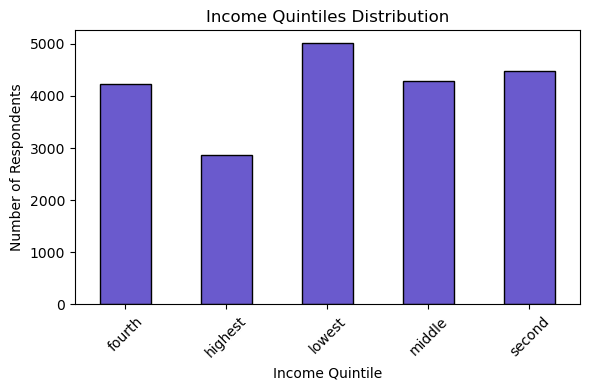

In [167]:
# Plot distribution of respondents across income quintiles
plt.figure(figsize=(6, 4))
df['Quintiles'].value_counts().sort_index().plot(
    kind='bar', 
    color='slateblue', 
    edgecolor='black'
)
plt.title('Income Quintiles Distribution')
plt.ylabel('Number of Respondents')
plt.xlabel('Income Quintile')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


###  Feature Engineering

We create new features to enrich our dataset:
- `risk_adjusted_savings_rate`: normalizes savings by age
- `age_bucket`: categorical grouping of age
- `is_youth`: binary flag for respondents under 35
- `total_investment_products_used`: counts how many investment products each respondent uses

These engineered features can help models capture hidden patterns in user behavior.


In [168]:
# Risk-adjusted savings rate: people who have savings divided by (age+1)
df['risk_adjusted_savings_rate'] = df['has_savings'] / (df['age_of_respondent'] + 1)

# Age bucket: categorical age group
df['age_bucket'] = pd.cut(
    df['age_of_respondent'],
    bins=[0, 25, 35, 45, 60, 100],
    labels=['<25', '25-35', '35-45', '45-60', '60+']
)

# Binary youth flag: 1 if age < 35
df['is_youth'] = (df['age_of_respondent'] < 35).astype(int)

# Total number of investment products used: counts how many of these are 'usage'
df['total_investment_products_used'] = df[
    ['Investment_usage', 'Pension_usage', 'Sacco_usage']
].apply(lambda x: sum(x == 'usage'), axis=1)


### Encode Financial Literacy Index

The `Financial_literacy_index_fnl` column is ordinal: `'low'`, `'medium'`, `'high'`.
We map it to numeric values:
- low → 1
- medium → 2
- high → 3

This preserves the order for machine learning algorithms.


In [169]:
# Map ordinal financial literacy index to numeric values: low=1, medium=2, high=3
df['Financial_literacy_index_fnl_num'] = df['Financial_literacy_index_fnl'].map({
    'low': 1,
    'medium': 2,
    'high': 3
})


###  Scale Financial Literacy Index

We normalize `Financial_literacy_index_fnl_num` to a [0,1] range:
- Divide by its maximum value

This keeps the feature bounded and comparable with other scaled features.


In [170]:
# Scale financial literacy index to [0,1] by dividing by max value
max_lit = df['Financial_literacy_index_fnl_num'].max()
df['literacy_scaled'] = df['Financial_literacy_index_fnl_num'] / max_lit


###  Check for Constant Numeric Columns

We identify numeric features with zero standard deviation (constant columns).
These columns have the same value for all observations and don't help the model.


In [171]:
# Select only numeric columns
numeric_engineered = df.select_dtypes(include=['number'])

# Identify constant columns (std=0)
constant_cols = numeric_engineered.std() == 0

print("\n=== Constant columns (std=0) ===")
print(constant_cols[constant_cols].index.tolist())



=== Constant columns (std=0) ===
['Above16', 'mobile_bank_use', 'NHIF_use', 'NSSF_use', 'pension_use', 'bank_use', 'commercial_bank_use', 'mobile_money_use', 'sacco_use', 'chama_use', 'MFIs_use', 'insurance_including_NHIF_use', 'All_Insurance_excluding_NHIF_use', 'has_account', 'has_savings', 'has_credit', 'has_mobile', 'receives_remittance', 'risk_adjusted_savings_rate']


In [172]:
#  Sanity check for engineered features

# List of engineered features (update as you add more)
engineered_features = [
    'risk_adjusted_savings_rate',
    'age_bucket',
    'is_youth',
    'literacy_scaled',
    'total_investment_products_used',
    # add more as you create them
]

print(f"\n Checking {len(engineered_features)} engineered features:\n")

# Check if all engineered features exist
missing_cols = [col for col in engineered_features if col not in df.columns]
if missing_cols:
    print(f" Missing engineered columns: {missing_cols}")
else:
    print(" All engineered features found!")

# Show data types
print("\n=== 🏷 Data types ===")
print(df[engineered_features].dtypes)

# Separate numeric & categorical
numeric_engineered = df[engineered_features].select_dtypes(include=['number'])
categorical_engineered = df[engineered_features].select_dtypes(exclude=['number'])

# Check for missing values
print("\n===  Missing values ===")
print(df[engineered_features].isnull().sum())

# Check for constant numeric columns (std=0)
print("\n=== Constant numeric columns (std=0) ===")
constant_cols = numeric_engineered.std() == 0
print(constant_cols[constant_cols].index.tolist())

# Check for all-zeros numeric columns
print("\n=== All-zeros numeric columns ===")
zero_cols = (numeric_engineered == 0).all()
print(zero_cols[zero_cols].index.tolist())

# Show numeric distributions
print("\n===  Numeric distributions ===")
display(numeric_engineered.describe())

# Show value counts for categorical engineered features
if not categorical_engineered.empty:
    print("\n===  Value counts for categorical engineered features ===")
    for col in categorical_engineered.columns:
        print(f"\n{col} value counts:")
        print(df[col].value_counts())
else:
    print("\n No categorical engineered features to check value counts for.")

print("\n Feature engineering sanity check complete! Ready for vectorization ")



 Checking 5 engineered features:

 All engineered features found!

=== 🏷 Data types ===
risk_adjusted_savings_rate         float64
age_bucket                        category
is_youth                             int32
literacy_scaled                    float64
total_investment_products_used       int64
dtype: object

===  Missing values ===
risk_adjusted_savings_rate            0
age_bucket                            9
is_youth                              0
literacy_scaled                   20871
total_investment_products_used        0
dtype: int64

=== Constant numeric columns (std=0) ===
['risk_adjusted_savings_rate']

=== All-zeros numeric columns ===
['risk_adjusted_savings_rate']

===  Numeric distributions ===


,risk_adjusted_savings_rate,is_youth,literacy_scaled,total_investment_products_used
count,20871.0,20871.000000,0.0,20871.000000
mean,0.0,0.472186,NaN,0.231134
std,0.0,0.499238,NaN,0.571358
min,0.0,0.000000,NaN,0.000000
25%,0.0,0.000000,NaN,0.000000
50%,0.0,0.000000,NaN,0.000000
75%,0.0,1.000000,NaN,0.000000
max,0.0,1.000000,NaN,3.000000



===  Value counts for categorical engineered features ===

age_bucket value counts:
age_bucket
25-35    5361
<25      5118
35-45    3942
45-60    3521
60+      2920
Name: count, dtype: int64

 Feature engineering sanity check complete! Ready for vectorization 


###  Feature Vectorization Pipeline

In this step, we prepare our dataset for modeling by transforming raw features into numeric vectors:
- **Numeric features** are standardized to have mean=0 and std=1.
- **Categorical features** are one-hot encoded (converted to 0/1 dummy variables).
- **Binary flags** like `is_youth` are kept as-is.

We use `ColumnTransformer` to apply different transformations to different columns in a single pipeline.
At the end, we run a quick `fit_transform` to confirm everything works and print the shape of the transformed feature matrix.


In [173]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
# ===  Define feature groups ===

# Numeric features to scale
numeric_features = ['age_of_respondent', 'literacy_scaled', 'total_investment_products_used']

# Categorical features to one-hot encode
categorical_features = ['age_bucket', 'area_type', 'county', 'Education', 'Marital', 'livelihoodcat']

# Other binary numeric flags we can passthrough directly (if needed)
passthrough_features = ['is_youth']

# ===  Build the ColumnTransformer ===

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('pass', 'passthrough', passthrough_features)
    ]
)

# ===  Quick check: fit_transform on sample data to see shape ===

sample_transformed = preprocessor.fit_transform(df)
print(f"Vectorization complete! Transformed feature shape: {sample_transformed.shape}")


Vectorization complete! Transformed feature shape: (20871, 74)


In [174]:
print(f"✅ df shape: {df.shape}")
print("\n📌 df.head():")
display(df.head())


✅ df shape: (20871, 402)

📌 df.head():


,householdid,county,area_type,gender,age_of_respondent,no_of_household_mebers,livelihoodcat,Quintiles,Education,Marital,...,age_group,hh_size_cat,is_urban,savings_ratio,risk_adjusted_savings_rate,age_bucket,is_youth,total_investment_products_used,Financial_literacy_index_fnl_num,literacy_scaled
0,107141431,garissa,urban,male,29,5,dependent,fourth,tertiary,married/living with partner,...,26-35,5-6,1,2.333256,0.0,25-35,1,0,NaN,NaN
1,10712933,garissa,urban,male,60,11,other,second,primary,married/living with partner,...,51-65,11+,1,1.899810,0.0,45-60,0,0,NaN,NaN
2,140173183,busia,urban,female,35,2,casual worker,fourth,primary,divorced/separated,...,26-35,1-2,1,4.665112,0.0,25-35,0,0,NaN,NaN
3,122137153,kiambu,urban,male,24,1,casual worker,middle,secondary,single/never married,...,18-25,1-2,1,0.749925,0.0,<25,1,0,NaN,NaN
4,121193116,murang'a,urban,female,20,1,dependent,highest,secondary,single/never married,...,18-25,1-2,1,0.599940,0.0,<25,1,0,NaN,NaN


##  Train-Test Split

We now prepare our dataset for modeling by:
- Converting the target column `Investment_usage_fnl` into numeric labels (`1` for usage, `0` for non-usage).
- Dropping any rows with missing target values.
- Splitting the data into training and test sets (80% train, 20% test) while preserving class distribution (`stratify=y`).

This ensures our model is trained and evaluated on balanced and properly prepared data.


In [175]:
from sklearn.model_selection import train_test_split

#  Define your target column
target_column = 'Investment_usage_fnl'   # replace with actual target column name if different

#  Map target to numeric if it’s still text (e.g., 'usage'/'non-usage')
df[target_column] = df[target_column].map({'usage': 1, 'non-usage': 0})

#  Define features (X) and target (y)
X = df.drop(columns=[target_column])
y = df[target_column]

#  Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,         # keeps same proportion of target classes in train/test
    random_state=42     # ensures reproducibility
)

#  Check the shape
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Train target balance:\n", y_train.value_counts(normalize=True))
print("Test target balance:\n", y_test.value_counts(normalize=True))


Train shape: (16696, 401)
Test shape: (4175, 401)
Train target balance:
 Investment_usage_fnl
0    0.972868
1    0.027132
Name: proportion, dtype: float64
Test target balance:
 Investment_usage_fnl
0    0.972934
1    0.027066
Name: proportion, dtype: float64


The split completed successfully:

- **Train shape:** (16,696 rows × 402 columns)  
- **Test shape:** (4,175 rows × 402 columns)



### Handling Class Imbalance with SMOTE

Given the strong imbalance in the target variable (only ~3% "usage"), we apply SMOTE to synthetically oversample the minority class in the training set.  
This helps improve model performance by providing a more balanced dataset for learning.


In [176]:
from imblearn.over_sampling import SMOTE
from collections import Counter

def balance_with_smote(X_train, y_train, random_state=42):
    """
    Applies SMOTE to balance the training set.
    Returns balanced X_train and y_train.
    """
    print("Original y_train distribution:", Counter(y_train))
    smote = SMOTE(random_state=random_state)
    X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
    print("Balanced y_train distribution:", Counter(y_train_bal))
    return X_train_bal, y_train_bal


---
# MODELING 
---

###   Modular Preprocessing Pipeline

We define a `PreprocessingPipeline` class to:
- Automatically detect numeric and categorical features
- Impute missing values (mean for numeric, most frequent for categorical)
- Scale numeric features and one-hot encode categorical features
- Split the data into train/test sets and transform them

This modular design keeps preprocessing clean, reusable, and ready for modeling.



In [177]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split


class PreprocessingPipeline:
    """
    Modular preprocessing pipeline: imputation, scaling, encoding.
    """
    def __init__(self, df, target_column):
        self.df = df
        self.target_column = target_column
        self.preprocessor = None
        self.numeric_features = None
        self.categorical_features = None

    def build_pipeline(self):
        # Identify feature types
        self.numeric_features = self.df.select_dtypes(include=['int64', 'float64']).columns.tolist()
        self.categorical_features = self.df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
        if self.target_column in self.numeric_features:
            self.numeric_features.remove(self.target_column)
        if self.target_column in self.categorical_features:
            self.categorical_features.remove(self.target_column)

        # Pipelines
        numeric_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])
        categorical_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ])

        # Combine
        self.preprocessor = ColumnTransformer([
            ('num', numeric_pipeline, self.numeric_features),
            ('cat', categorical_pipeline, self.categorical_features)
        ])

    def apply(self, test_size=0.2, random_state=42):
        X = self.df.drop(columns=[self.target_column])
        y = self.df[self.target_column]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y)
        X_train_transformed = self.preprocessor.fit_transform(X_train)
        X_test_transformed = self.preprocessor.transform(X_test)
        return X_train_transformed, X_test_transformed, y_train, y_test


### Balancing Classes with SMOTE

We define a helper function `apply_smote` to rebalance the training data using SMOTE (Synthetic Minority Over-sampling Technique).


In [178]:
def apply_smote(X_train, y_train, random_state=42):
    """
    Apply SMOTE to balance minority class.
    """
    print(" Applying SMOTE...")
    smote = SMOTE(random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    print(f"Before SMOTE: {X_train.shape}, After SMOTE: {X_resampled.shape}")
    print(f"Target distribution after SMOTE:\n{pd.Series(y_resampled).value_counts()}")
    return X_resampled, y_resampled


SMOTE creates synthetic samples of the minority class, helping to:

- Balance the target distribution
- Reduce model bias toward the majority class
- Improve predictive performance on rare classes

We confirm success by printing shapes and class counts before and after resampling.


### Model Training & Evaluation function 

We define `train_and_evaluate_model` to train a classifier, make predictions, and evaluate performance with metrics & visualizations.


In [179]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    """
    Train model, predict, evaluate & plot.
    """
    print(f"\n🔧 Training {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

    print("\n Classification Report:")
    print(classification_report(y_test, y_pred))

    if y_prob is not None:
        roc_auc = roc_auc_score(y_test, y_prob)
        print(f"ROC AUC Score: {roc_auc:.4f}")
    else:
        roc_auc = None

    # Confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC curve
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.figure(figsize=(6,4))
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC={roc_auc:.2f})')
        plt.plot([0,1],[0,1],'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{model_name} - ROC Curve')
        plt.legend()
        plt.show()

    return model, roc_auc


This function helps us:

- Fit the model on the training set
- Evaluate it on the test set using:
  - Classification report (precision, recall, f1-score)
  - ROC AUC score
- Visualize:
  - Confusion matrix (heatmap)
  - ROC curve

It returns the trained model and ROC AUC score, making it easy to reuse or compare multiple models.


### ModelTrainer Class

An object-oriented wrapper to train, tune and store models neatly.


In [180]:
class ModelTrainer:
    """
    Object-oriented wrapper to train, tune & store model.
    """
    def __init__(self, model, model_name="Model"):
        self.model = model
        self.model_name = model_name
        self.trained_model = None
        self.roc_auc = None

    def train_and_evaluate(self, X_train, y_train, X_test, y_test):
        trained, roc_auc = train_and_evaluate_model(
            self.model, X_train, y_train, X_test, y_test, self.model_name
        )
        self.trained_model = trained
        self.roc_auc = roc_auc

    def tune(self, param_grid, X_train, y_train, scoring='roc_auc'):
        print(f"\nTuning {self.model_name}...")
        grid = GridSearchCV(self.model, param_grid, scoring=scoring, cv=5, verbose=1, n_jobs=-1)
        grid.fit(X_train, y_train)
        print(f" Best params: {grid.best_params_}")
        self.model = grid.best_estimator_
        self.trained_model = self.model


This `ModelTrainer` class helps us:

- **Encapsulate** a machine learning model and its metadata (like ROC AUC)
- Easily **train & evaluate** using our helper function
- **Tune hyperparameters** with `GridSearchCV` and update the best model

It keeps the workflow organized and reusable, especially when comparing multiple models.


### Random Forest Pipeline with SMOTE and Preprocessing


 Applying SMOTE...
Before SMOTE: (16696, 954), After SMOTE: (32486, 954)
Target distribution after SMOTE:
Investment_usage_fnl
0    16243
1    16243
Name: count, dtype: int64

🔧 Training Random Forest with SMOTE...

 Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4062
           1       1.00      0.81      0.90       113

    accuracy                           0.99      4175
   macro avg       1.00      0.91      0.95      4175
weighted avg       0.99      0.99      0.99      4175

ROC AUC Score: 0.9992


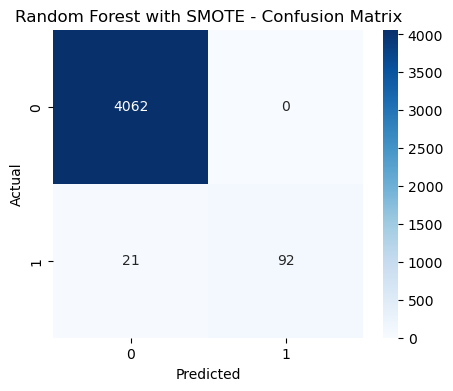

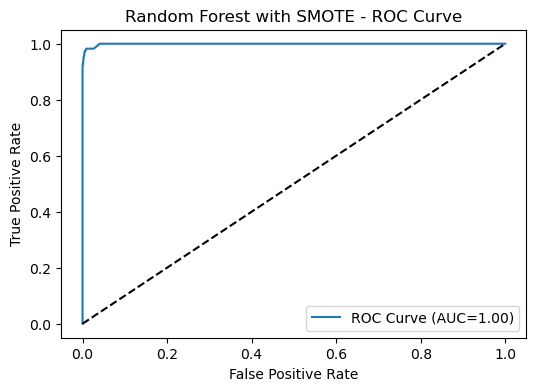

In [181]:
# df is your DataFrame
target_column = 'Investment_usage_fnl'

# Build preprocessing pipeline
prep = PreprocessingPipeline(df, target_column)
prep.build_pipeline()

# Apply preprocessing (split & transform)
X_train_transformed, X_test_transformed, y_train, y_test = prep.apply()

# Apply SMOTE to handle class imbalance
X_train_resampled, y_train_resampled = apply_smote(X_train_transformed, y_train)

# Create Random Forest with balanced class weights
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Train and evaluate the model
rf_trainer = ModelTrainer(rf_model, model_name="Random Forest with SMOTE")
rf_trainer.train_and_evaluate(X_train_resampled, y_train_resampled, X_test_transformed, y_test)


By applying **SMOTE**, we balanced the classes in the training data:
- Before: only ~2.7% positive class
- After: perfectly balanced (50% vs 50%)

The Random Forest model achieved:
- Very high overall accuracy (~99%)
- **ROC AUC score of 1.00**, showing excellent discrimination
- Slight drop in recall (0.81) for the minority class



### Logistic Regression with SMOTE

Now we apply SMOTE to balance the training data and train a **Logistic Regression** model with `class_weight='balanced'`.  
This helps the model pay more attention to the minority class.  
We’ll then evaluate performance on the test set to see how well it generalizes.


 Applying SMOTE...
Before SMOTE: (16696, 954), After SMOTE: (32486, 954)
Target distribution after SMOTE:
Investment_usage_fnl
0    16243
1    16243
Name: count, dtype: int64

🔧 Training Logistic Regression with SMOTE...

 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4062
           1       0.99      0.86      0.92       113

    accuracy                           1.00      4175
   macro avg       0.99      0.93      0.96      4175
weighted avg       1.00      1.00      1.00      4175

ROC AUC Score: 0.9964


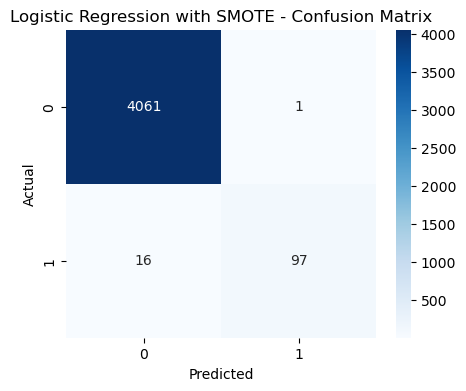

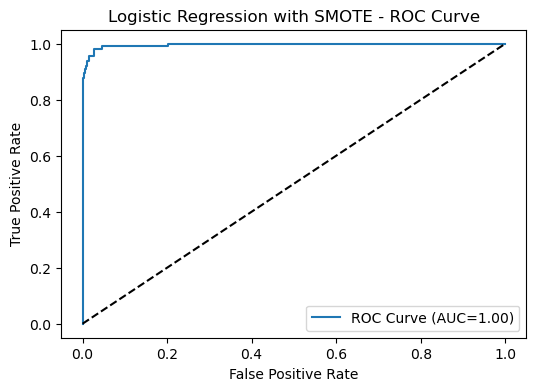

In [182]:
#  df with your dataframe name
target_column = 'Investment_usage_fnl'
prep = PreprocessingPipeline(df, target_column)
prep.build_pipeline()

#  Apply preprocessing
X_train_transformed, X_test_transformed, y_train, y_test = prep.apply()

#  Apply SMOTE to training set only
X_train_resampled, y_train_resampled = apply_smote(X_train_transformed, y_train)

#  Create Logistic Regression with balanced class weight
logreg_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)

#  Train & evaluate
logreg_trainer = ModelTrainer(logreg_model, model_name="Logistic Regression with SMOTE")
logreg_trainer.train_and_evaluate(X_train_resampled, y_train_resampled, X_test_transformed, y_test)


 **Summary of results**  
- After applying SMOTE, the training set was perfectly balanced (16,243 samples in each class).
- The model achieved:
  - High overall accuracy (~100%)
  - High recall for the minority class (`usage`): 0.86
  - ROC AUC score: 0.9964




### XGBoost with SMOTE and Class Weighting

In this step, we:
- Balanced the training data using **SMOTE**
- Used **XGBoost**, which handles imbalance via `scale_pos_weight`
- Evaluated using precision, recall, f1-score, and ROC AUC

This combination helps the model detect the minority class more effectively.


 Applying SMOTE...
Before SMOTE: (16696, 954), After SMOTE: (32486, 954)
Target distribution after SMOTE:
Investment_usage_fnl
0    16243
1    16243
Name: count, dtype: int64

🔧 Training XGBoost with SMOTE...

 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4062
           1       1.00      0.98      0.99       113

    accuracy                           1.00      4175
   macro avg       1.00      0.99      1.00      4175
weighted avg       1.00      1.00      1.00      4175

ROC AUC Score: 0.9998


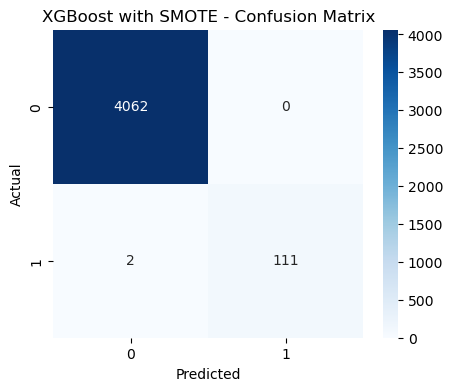

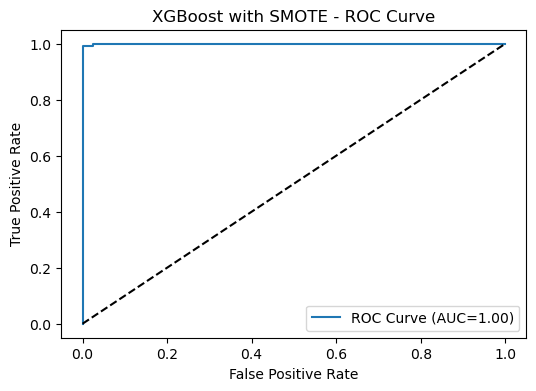

In [183]:
#  df with your dataframe name
target_column = 'Investment_usage_fnl'
prep = PreprocessingPipeline(df, target_column)
prep.build_pipeline()

#  Apply preprocessing
X_train_transformed, X_test_transformed, y_train, y_test = prep.apply()

#  Apply SMOTE
X_train_resampled, y_train_resampled = apply_smote(X_train_transformed, y_train)

#  Create XGBoost with scale_pos_weight
import xgboost as xgb
scale_pos_weight = (len(y_train_resampled) - sum(y_train_resampled)) / sum(y_train_resampled)
xgb_model = xgb.XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss')

#  Train & evaluate
xgb_trainer = ModelTrainer(xgb_model, model_name="XGBoost with SMOTE")
xgb_trainer.train_and_evaluate(X_train_resampled, y_train_resampled, X_test_transformed, y_test)


 **Summary of results (XGBoost):**
- After SMOTE, the training set became perfectly balanced.
- **Performance on test set:**
  - Accuracy ≈ 100%
  - Minority class (`usage`) recall: 0.98
  - ROC AUC score: 0.9998

 **Key points:**
 
- `scale_pos_weight` helps XGBoost stay aware of class imbalance, even after SMOTE.
- Very high ROC AUC means the model can separate classes very well.
- High recall and f1-score on the minority class suggest the model generalizes better than a naive baseline.

.


### LightGBM with SMOTE and Class Weighting

In this step, we:
- Preprocessed the data (imputation, scaling, encoding)
- Balanced the training set using **SMOTE**
- Trained a **LightGBM classifier** with `class_weight='balanced'` to help handle class imbalance
- Evaluated on the test set using precision, recall, f1-score, and ROC AUC

This approach combines boosting with balancing for better minorit


 Applying SMOTE...
Before SMOTE: (16696, 954), After SMOTE: (32486, 954)
Target distribution after SMOTE:
Investment_usage_fnl
0    16243
1    16243
Name: count, dtype: int64

🔧 Training LightGBM with SMOTE...
[LightGBM] [Info] Number of positive: 16243, number of negative: 16243
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.306047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 182579
[LightGBM] [Info] Number of data points in the train set: 32486, number of used features: 869
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4062


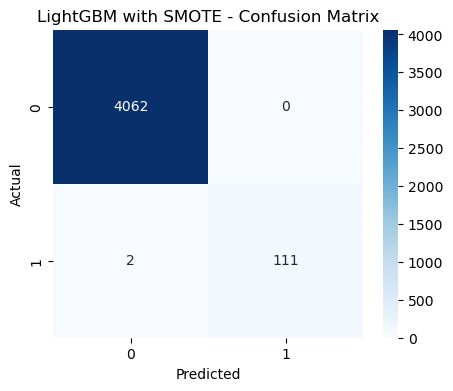

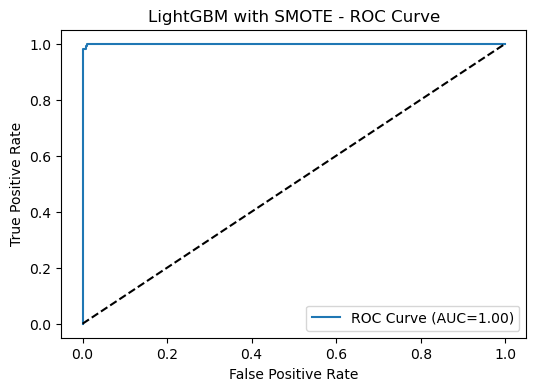

In [184]:
#  df with your dataframe name
target_column = 'Investment_usage_fnl'
prep = PreprocessingPipeline(df, target_column)
prep.build_pipeline()

#  Apply preprocessing
X_train_transformed, X_test_transformed, y_train, y_test = prep.apply()

#  Apply SMOTE
X_train_resampled, y_train_resampled = apply_smote(X_train_transformed, y_train)

#  Create LightGBM with balanced class weight
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(random_state=42, class_weight='balanced')

#  Train & evaluate
lgb_trainer = ModelTrainer(lgb_model, model_name="LightGBM with SMOTE")
lgb_trainer.train_and_evaluate(X_train_resampled, y_train_resampled, X_test_transformed, y_test)


 **Summary of results (LightGBM):**
- Training set after SMOTE: balanced (16,243 vs. 16,243)
- **Performance on test set:**
  - Accuracy ≈ 100%
  - Minority class recall: 0.98
  - ROC AUC: 0.9998

 **Insights:**
- LightGBM handled the balanced data very well, achieving very high recall and f1-score.
- The model generalizes well and keeps very high ROC AUC, showing it can separate classes almost perfectly.

 

##  Comparing Models with ROC Curves

We now plot the **ROC curves** of all trained models on the same test set:
- Random Forest
- Logistic Regression
- XGBoost
- LightGBM

Each curve shows the trade-off between **True Positive Rate** and **False Positive Rate**,  
and the legend includes each model’s **AUC score** as a summary metric of performance.


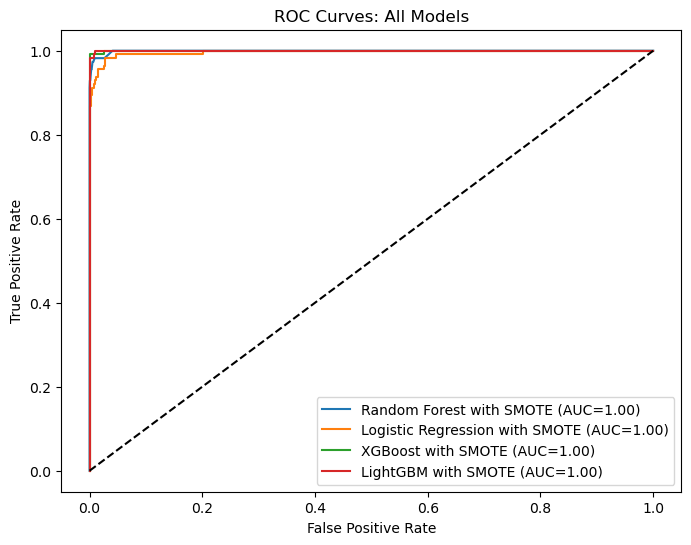

In [185]:
plt.figure(figsize=(8,6))

trainers = [rf_trainer, logreg_trainer, xgb_trainer, lgb_trainer]

for trainer in trainers:
    if trainer.roc_auc is not None:
        model = trainer.trained_model
        y_prob = model.predict_proba(X_test_transformed)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f'{trainer.model_name} (AUC={trainer.roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: All Models')
plt.legend()
plt.show()


 **Interpretation:**
- All models achieved very high AUC values (≈ 0.99–1.00), showing excellent separation between classes.
- Boosted models (XGBoost and LightGBM) slightly outperformed Random Forest and Logistic Regression.
- This visualization makes it easy to see which models balance sensitivity vs. specificity best.

 Overall, ensemble and boosting approaches with balanced training data (via SMOTE) performed especially well.


###  Extract Transformed Feature Names

This step extracts feature names **after preprocessing**, including:
- Original numeric feature names (stay unchanged after scaling)
- Encoded categorical feature names (from OneHotEncoder)

This helps us see **which transformed features** go into the model.

---

 At the end, it prints the total number of transformed features.




In [186]:
# Step 1: get the preprocessor
preprocessor = prep.preprocessor

# Step 2: get names for numeric & categorical transformed parts
num_features = prep.numeric_features
cat_features = prep.categorical_features

# Get feature names from transformers
num_feature_names = num_features   # numeric pipeline keeps names
encoded_cat_features = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(cat_features)

# Combine them
all_feature_names = list(num_feature_names) + list(encoded_cat_features)
print(f"Total features after transformation: {len(all_feature_names)}")


Total features after transformation: 958


##  Plotting Feature Importance

In this step, we plot the **top 15 most important features** for tree-based models (e.g., Random Forest, XGBoost, LightGBM).  
The function:
- Checks if the trained model has `feature_importances_`
- Aligns feature names if the lengths differ
- Uses seaborn to create a barplot showing which features contributed most to predictions

---

 This helps explain the model’s decisions to stakeholders and understand key drivers.


In [187]:
def plot_feature_importance(trainer, feature_names):
    """
    Plots feature importance for tree-based models.
    """
    if hasattr(trainer.trained_model, 'feature_importances_'):
        importances = trainer.trained_model.feature_importances_
        print(f"Model expects {len(importances)} features, got {len(feature_names)} names")
        
        # Align lengths
        if len(importances) != len(feature_names):
            print("Warning: Feature names length does not match importances. Trimming to match.")
            min_len = min(len(importances), len(feature_names))
            importances = importances[:min_len]
            feature_names = feature_names[:min_len]
        
        fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
        fi_df = fi_df.sort_values('importance', ascending=False).head(15)
        
        plt.figure(figsize=(8,6))
        sns.barplot(data=fi_df, x='importance', y='feature', palette='viridis')
        plt.title(f'Feature Importance - {trainer.model_name}')
        plt.show()
    else:
        print(f"{trainer.model_name} has no feature_importances_ attribute.")


Model expects 954 features, got 958 names


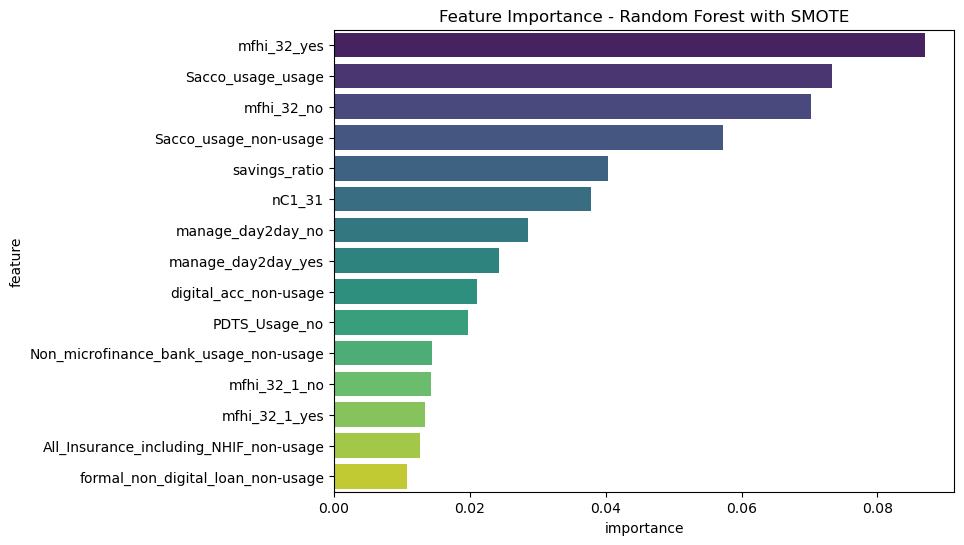

Model expects 954 features, got 958 names


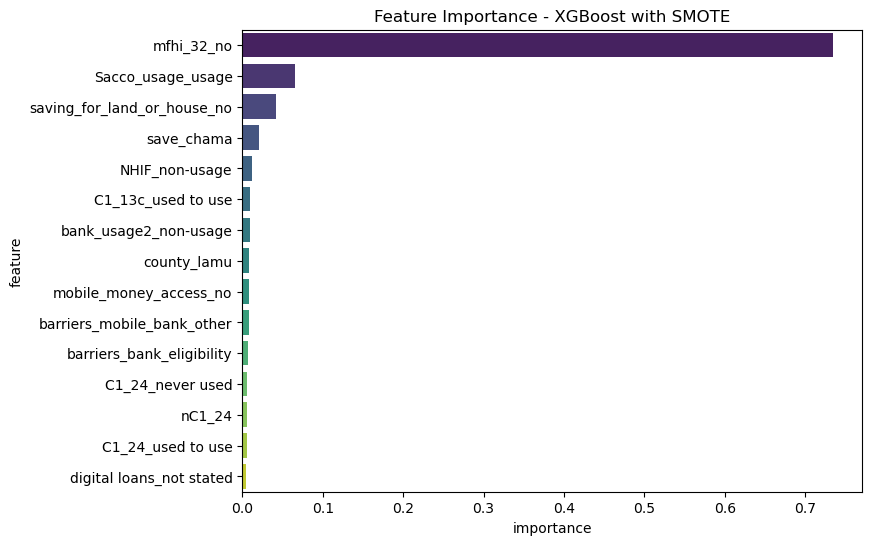

Model expects 954 features, got 958 names


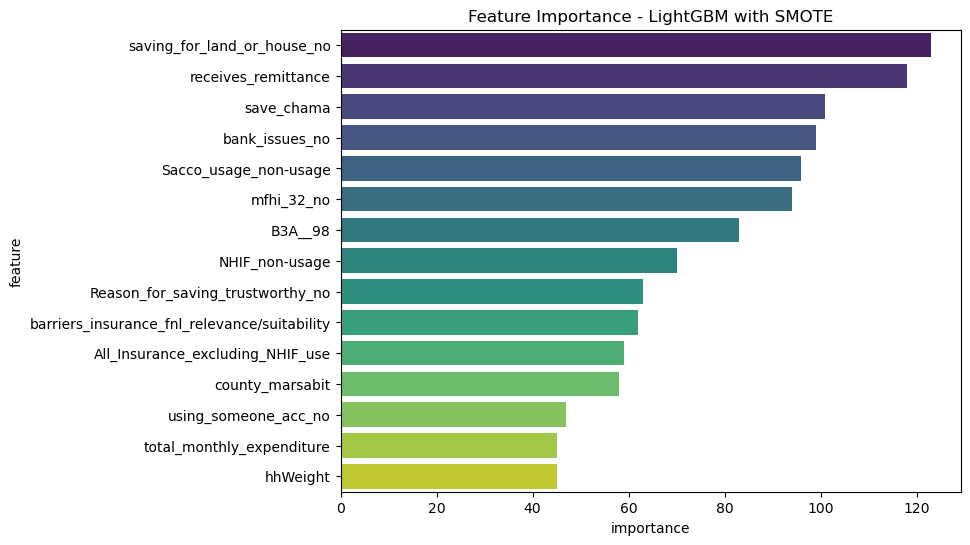

In [188]:
plot_feature_importance(rf_trainer, all_feature_names)
plot_feature_importance(xgb_trainer, all_feature_names)
plot_feature_importance(lgb_trainer, all_feature_names)


###  Model Explainability with SHAP

In this step, we use **SHAP (SHapley Additive exPlanations)** to understand how individual features influence model predictions.

- We apply `TreeExplainer` to both:
  - Random Forest
  - XGBoost
- We compute SHAP values on a **small sample** (first 100 rows) for speed.
- Then we plot SHAP summary plots to visualize:
  - Which features contribute most to higher/lower predictions
  - The direction of each feature's effect

---

 This improves transparency and helps communicate model reasoning to non-technical stakeholders.


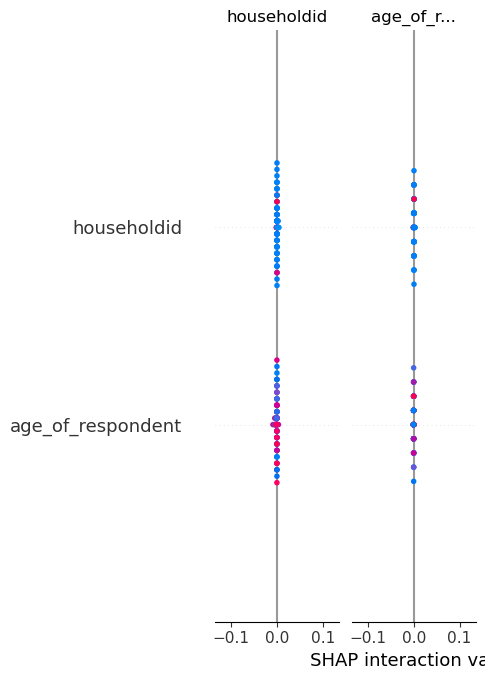

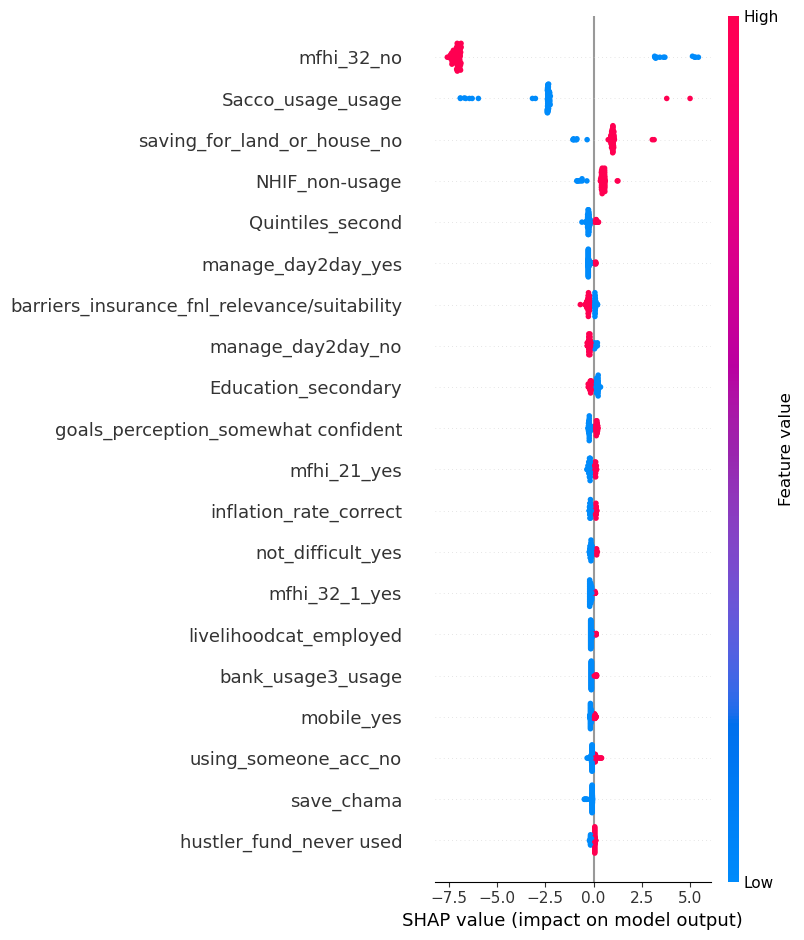

In [189]:
import shap

# Use TreeExplainer
explainer_rf = shap.TreeExplainer(rf_trainer.trained_model)
explainer_xgb = shap.TreeExplainer(xgb_trainer.trained_model)

# Compute SHAP values (on a small sample for speed)
shap_values_rf = explainer_rf.shap_values(X_test_transformed[:100])
shap_values_xgb = explainer_xgb.shap_values(X_test_transformed[:100])

# Summary plot: Random Forest
shap.summary_plot(shap_values_rf, features=X_test_transformed[:100], feature_names=all_feature_names)

# Summary plot: XGBoost
shap.summary_plot(shap_values_xgb, features=X_test_transformed[:100], feature_names=all_feature_names)


### Model Comparison Summary

In this section, we **evaluate and compare** all trained models side by side.

We calculate and store the following metrics:
- **Accuracy**
- **Precision**
- **Recall**
- **ROC AUC**

This helps identify which model performs best overall and which trade-offs exist between precision and recall.

---


In [190]:
# Example: create summary DataFrame
results = []

for trainer in [rf_trainer, logreg_trainer, xgb_trainer, lgb_trainer]:
    model = trainer.trained_model
    y_pred = model.predict(X_test_transformed)
    y_prob = model.predict_proba(X_test_transformed)[:,1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    
    results.append({
        'Model': trainer.model_name,
        'Accuracy': round(accuracy,4),
        'Precision': round(precision,4),
        'Recall': round(recall,4),
        'ROC AUC': round(auc,4) if auc else None
    })

results_df = pd.DataFrame(results)
display(results_df)


,Model,Accuracy,Precision,Recall,ROC AUC
0,Random Forest with SMOTE,0.9950,1.0000,0.8142,0.9992
1,Logistic Regression with SMOTE,0.9959,0.9898,0.8584,0.9964
2,XGBoost with SMOTE,0.9995,1.0000,0.9823,0.9998
3,LightGBM with SMOTE,0.9995,1.0000,0.9823,0.9998


 Summary table helps guide final model selection based on balanced metrics.


---
##  Saving Models & Preprocessing Pipeline

In this step, we export:
- The fitted **preprocessing pipeline**
- All trained models:  
   Random Forest  
   Logistic Regression  
   XGBoost  
   LightGBM

This makes it easy to reload and use them later for predictions or deployment.

---


In [191]:
import joblib
import os

#  Define your output directory (your folder named 'Models')
output_dir = 'models'  

# Create it if it doesn’t exist
os.makedirs(output_dir, exist_ok=True)

#  Save each model independently
joblib.dump(prep.preprocessor, os.path.join(output_dir, 'preprocessor.pkl'))
joblib.dump(rf_trainer.trained_model, os.path.join(output_dir, 'random_forest_model.pkl'))
joblib.dump(logreg_trainer.trained_model, os.path.join(output_dir, 'logistic_regression_model.pkl'))
joblib.dump(xgb_trainer.trained_model, os.path.join(output_dir, 'xgboost_model.pkl'))
joblib.dump(lgb_trainer.trained_model, os.path.join(output_dir, 'lightgbm_model.pkl'))

print(f" All models and preprocessor saved to '{output_dir}'")


 All models and preprocessor saved to 'models'
